## Food-Vision 

1. Problem
2. Data
3. Evaluation

## 1. Problem
The project is aimed on creating a full-stock functioning model on the full data from the previous project that was based only on three subsets of the entire dataset

## 2. Data
Dataset was downloaded from 101-Food dataset website

## 3. Evaluation
Evaluation metric is going to be accuracy

In [1]:
import torch as pt
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
from torch import nn
from torchinfo import summary
from pathlib import Path

C:\Users\pwrxn\miniconda3\envs\pytorch\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
from going_modular import data_setup, engine

## Importing data

In [3]:
data_path = Path('data/')
image_path = data_path / 'archive/food-101/food-101'

if image_path.is_dir():
    print(f'[INFO] {image_path} exists!')

[INFO] data\archive\food-101\food-101 exists!


## Creating Train and Test datasets

In [4]:
import os
import shutil
import json

In [31]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

os.makedirs(train_dir, exist_ok =True)
os.makedirs(test_dir, exist_ok=True)

# Read the json or txt files to get the mappings
with open(image_path / 'meta/train.json', 'r') as f:
    train_data = json.load(f)

with open(image_path / 'meta/test.json', 'r') as f:
    test_data = json.load(f)

def distribute_images(data, source_dir, target_dir):
    for category, images in data.items():
        # Create category sub-directory in target_dir
        category_dir = os.path.join(target_dir, category)
        os.makedirs(category_dir, exist_ok=True)

        for image in images:
            src_path = os.path.join(source_dir, 'images', image + '.jpg')  

            # Construct the destination path by combining the category directory and image file name
            dst_path = os.path.join(category_dir, os.path.basename(image) + '.jpg')

            # Copy the image to the new directory if it exists
            if os.path.exists(src_path):
                shutil.copy(src_path, dst_path)
            else:
                print(f"File not found: {src_path}")

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'data\\archive\\food-101\\food-101\\test\\risotto\\1326797.jpg\\train'

In [22]:
# Distribute the train and test images
distribute_images(train_data, image_path, train_dir)
distribute_images(test_data, image_path, test_dir)

## Create Datasets and Dataloaders

In [6]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [7]:
# Get the transforms used to create our pretrianed weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [8]:
# Create dataloader using automatic transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x23b7f897cd0>,
 ['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito',
  'bruschetta',
  'caesar_salad',
  'cannoli',
  'caprese_salad',
  'carrot_cake',
  'ceviche',
  'cheese_plate',
  'cheesecake',
  'chicken_curry',
  'chicken_quesadilla',
  'chicken_wings',
  'chocolate_cake',
  'chocolate_mousse',
  'churros',
  'clam_chowder',
  'club_sandwich',
  'crab_cakes',
  'creme_brulee',
  'croque_madame',
  'cup_cakes',
  'deviled_eggs',
  'donuts',
  'dumplings',
  'edamame',
  'eggs_benedict',
  'escargots',
  'falafel',
  'filet_mignon',
  'fish_and_chips',
  'foie_gras',
  'french_fries',
  'french_onion_soup',
  'french_toast',
  'fried_calamari',
  'fried_rice',
  'frozen_yogurt',
  'garlic_bread',
  'gnocchi',
  'greek_salad',
  'grilled_cheese_sandwich',
  'grilled_salmon',
  'guacamole',
  'gyoza',
  'hamburger',
  'hot

In [9]:
len(class_names)

101

## Getting a pretrained model

In [10]:
model = torchvision.models.efficientnet_b0(weights=weights)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [11]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### Given pretrained model was trained on more than 1000 instances of data while our dataset consists only of 101 classes. We should make some adjustments in code

## Get a summary of our model with `torchinfo.summary()`

In [12]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

## Freezing the base model and changing the output layer to suit our needs

In [13]:
summary(model=model,
        input_size=(1,3,224,224),
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

In [14]:
# Freeze all the base layers in EffNetB0
for param in model.features.parameters():
    param.requires_grad = False

In [15]:
# Update the classifier head of our model to suit our problem
pt.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
              out_features=len(class_names))
)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=101, bias=True)
)

In [16]:
summary(model=model,
        input_size=(1,3,224,224),
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## Training a model

In [17]:
# define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = pt.optim.Adam(model.parameters(), lr=0.001)

In [30]:
# Set the manual seeds
pt.manual_seed(42)

# Set the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device='cpu')

# End the timer and print out how long it took
end_time = timer()
print(f'[INFO] Total training time: {end_time - start_time:.3f} seconds')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.7771 | train_acc: 0.5521 | test_loss: 1.6066 | test_acc: 0.5916
Epoch: 2 | train_loss: 1.7696 | train_acc: 0.5527 | test_loss: 1.5861 | test_acc: 0.5970
Epoch: 3 | train_loss: 1.7758 | train_acc: 0.5520 | test_loss: 1.5760 | test_acc: 0.6010
Epoch: 4 | train_loss: 1.7784 | train_acc: 0.5526 | test_loss: 1.6159 | test_acc: 0.5907
Epoch: 5 | train_loss: 1.7734 | train_acc: 0.5512 | test_loss: 1.5784 | test_acc: 0.5987
[INFO] Total training time: 12357.973 seconds


In [19]:
from helper_functions import plot_loss_curves

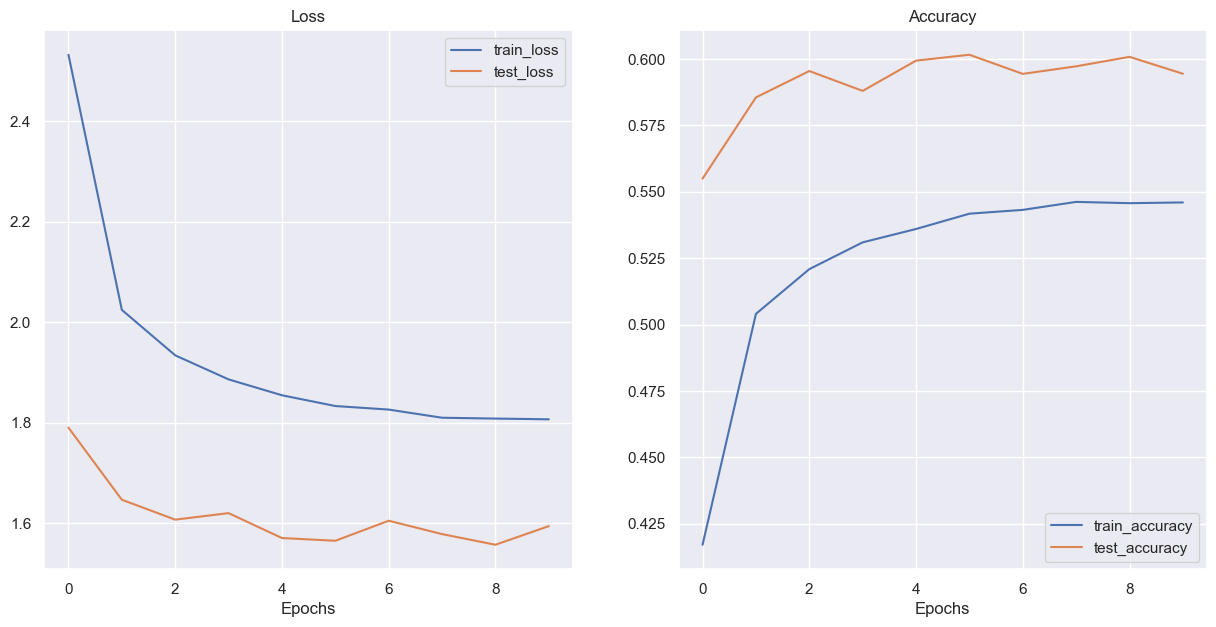

In [20]:
plot_loss_curves(results)

In [21]:
from typing import List, Tuple

from PIL import Image
from PIL import ImageOps

def pred_and_plot_image(model: pt.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224,224),
                        transform: torchvision.transforms = None):

    img = Image.open(image_path)
    img = ImageOps.exif_transpose(img)

    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406],
                                 std=[0.229,0.224,0.225])
        ])

    # Predict image
    model.eval()
    with pt.inference_mode():
        transformed_image = image_transform(img).unsqueeze(dim=0)

        target_image_pred = model(transformed_image)

    target_image_pred_probs = pt.softmax(target_image_pred, dim=1)

    target_image_pred_label = pt.argmax(target_image_pred_probs, dim=1)

    plt.figure()
    plt.axis(False)
    plt.imshow(img)
    plt.title(f'Pred {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}')

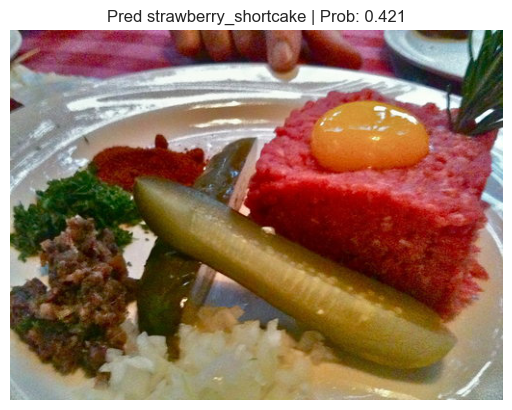

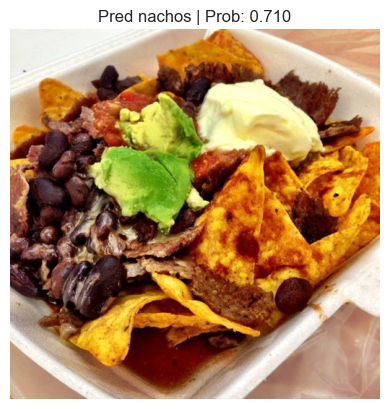

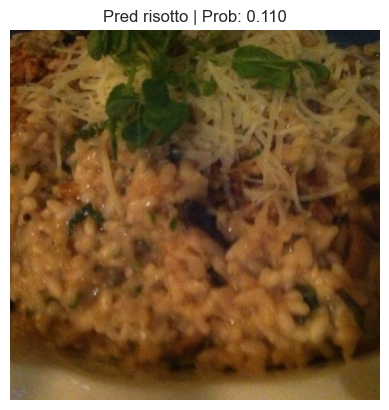

In [22]:
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob('*/*.jpg'))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)

for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224,224))

## Saving the model

In [27]:
from going_modular import utils

utils.save_model(model=model,
           target_dir='ML_projects/Pytorch/models',
           model_name='Full_model_EffNet0.pth')

[INFO] Saving model to: ML_projects\Pytorch\models\Full_model_EffNet0.pth


In [32]:
pt.save(model, 'ML_projects/Pytorch/models/Full_model_EffNetB0.pth')

In [33]:
# Setup a SummaryWriter
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
writer

In [39]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

from going_modular.engine import train_step, test_step

def train(model: pt.nn.Module, 
          train_dataloader: pt.utils.data.DataLoader, 
          test_dataloader: pt.utils.data.DataLoader, 
          optimizer: pt.optim.Optimizer,
          loss_fn: pt.nn.Module,
          epochs: int,
          device: pt.device,
          writer: pt.utils.tensorboard.writer.SummaryWriter) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ###New: Experiment tracking ###
        if writer:
        
            writer.add_scalars(main_tag='Loss',
                               tag_scalar_dict={'train_loss': train_loss,
                                                'test_loss': test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag='Accuracy',
                               tag_scalar_dict={'train_acc': train_acc,
                                                'test_acc': test_acc},
                               global_step=epoch)
    
            writer.add_graph(model=model,
                             input_to_model=pt.randn(32,3,224,224))

            writer.close()
        else:
            pass
    # Return the filled results at the end of the epochs
    return results

In [40]:
OUT_FEATURES = len(class_names)

def create_effnetb2():
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights)

    for param in model.features.parameters():
        param.requires_grad = False

    pt.manual_seed(42)
    model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    )
    model.name = 'effnetb2'
    print(f'[INFO] Created new {model.name} model...')
    return model

In [41]:
effnetb2 = create_effnetb2()

[INFO] Created new effnetb2 model...


In [ ]:
results = train(model=effnetb2,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,